In [1]:
# import warnings
# warnings.filterwarnings('ignore')

import GEOparse
from tqdm import tqdm
import urllib.request
import random
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

from scvi.dataset import AnnDatasetFromAnnData

import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import umap

from utils_helper import *

seed = 345
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)


gpus = ["1"]
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(gpus)
device = 'cuda:0'

[2020-04-20 18:31:50,199] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
Using TensorFlow backend.


# Load Data

In [8]:
path = "path_to_dataset.h5ad"
adata = sc.read_h5ad(path)

In [9]:
id2age = {10:19,11:19,12:24,15:30,17:41,20:31,31:21,36:27,48:26,55:54,58:22,67:22,84:29,104:87,118:51,127:82,133:42,134:42,135:18,142:47,149:77,150:52,167:30,173:20,183:64,184:34,185:48,215:43,216:55,225:44,250:26,251:44,305:32,315:53}
adata.obs['age'] = adata.obs['patient_id'].map(id2age)
adata.obs['age_bin'] = (adata.obs['age'].astype('int32') / 10).astype('int32').astype('category')

In [10]:
adata.obs['cell_types'] = adata.obs['cell_group'].values
adata.obs['cell_type'] = adata.obs['cell_group'].values
adata.obs['labels'] = adata.obs['cell_group'].astype('category').cat.codes.values

adata.obs['batch_name'] = adata.obs['age'].values
adata.obs['batch'] = adata.obs['batch_name']
adata.obs['batch_indices'] =  adata.obs['batch']

n_labels = len(adata.obs['cell_types'].unique())
n_batch = len(adata.obs['batch'].unique())

In [11]:
# sc.pp.subsample(adata, fraction=0.2, random_state = seed) # todo

In [12]:
dataset = AnnDatasetFromAnnData(adata)

[2020-04-20 18:32:30,482] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-20 18:32:30,486] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-20 18:32:30,728] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-20 18:32:30,906] INFO - scvi.dataset.dataset | Downsampled from 15522 to 15522 cells


# Preprocess

In [ ]:
# sc.pp.log1p(adata)

# Latent Inference

In [26]:
n_epochs = 50
lr = 0.001
eps = 1e-8
use_batches = True
use_cuda = True
n_latent = 10
%matplotlib inline

In [27]:
vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches * use_batches, n_latent=n_latent, n_layers = 2, n_hidden=64)

In [28]:
# disc = Discriminator(n_latent, [2*n_latent], n_batch).to('cuda:0')
disc = Regressor(n_latent, [2*n_latent], n_batch).to('cuda:0')

In [29]:
trainer = GANTrainer(
    vae, 
    disc,
    dataset,
    train_size=0.9999999999999,  test_size=None, # train_size=0.9, test_size=0.05,
    use_cuda=use_cuda,
    frequency=5,
    seed = seed
)


In [30]:
history = trainer.train(n_epochs=150, lr= lr*1, eps=eps, disc_lr= lr * 1, enc_lr = lr* 0.0 )

training: 100%|██████████| 150/150 [19:40<00:00,  7.87s/it]


In [283]:
history = trainer.train(n_epochs=50, lr= lr*1, eps=eps, disc_lr= lr * 1, enc_lr = lr* 0.05)



training:   0%|          | 0/50 [00:00<?, ?it/s]

training:   2%|▏         | 1/50 [00:07<06:11,  7.58s/it]

training:   4%|▍         | 2/50 [00:14<05:59,  7.49s/it]

training:   6%|▌         | 3/50 [00:22<05:49,  7.43s/it]

training:   8%|▊         | 4/50 [00:29<05:43,  7.48s/it]

training:  10%|█         | 5/50 [00:37<05:38,  7.52s/it]

training:  12%|█▏        | 6/50 [00:44<05:30,  7.52s/it]

training:  14%|█▍        | 7/50 [00:52<05:23,  7.53s/it]

training:  16%|█▌        | 8/50 [01:00<05:17,  7.56s/it]

training:  18%|█▊        | 9/50 [01:07<05:12,  7.63s/it]

training:  20%|██        | 10/50 [01:15<05:00,  7.51s/it]

training:  22%|██▏       | 11/50 [01:22<04:50,  7.45s/it]

training:  24%|██▍       | 12/50 [01:29<04:40,  7.37s/it]

training:  26%|██▌       | 13/50 [01:36<04:31,  7.33s/it]

training:  28%|██▊       | 14/50 [01:44<04:25,  7.37s/it]

training:  30%|███       | 15/50 [01:51<04:21,  7.47s/it]

training:  32%|███▏      | 16/50 [01:59<04:11,  7.41s/it]

training:  34

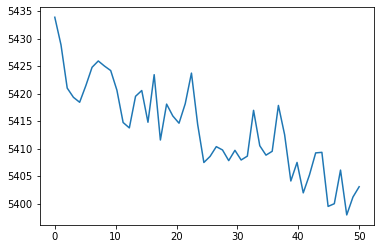

In [284]:
elbo_train = history[0] 
x = np.linspace(0, len(elbo_train), len(elbo_train))
plt.plot(x, elbo_train)

In [285]:
posterior = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batches, labels = posterior.sequential().get_latent()

In [286]:
adata.obsm["X_scVI"] = latent

In [287]:
latent_tensor = torch.tensor(latent, device='cuda:0')

In [288]:
batch_prediction = np.argmax(disc(latent_tensor).detach().cpu().numpy(), axis=1)

# Clustering Scores by kmeans

In [24]:
def calc_scores(input_posterior):
    latent, batches, labels = input_posterior.sequential().get_latent()
    print("Entropy of batch mixing :", entropy_batch_mixing(latent,batches))
    print("Clustering ARI = {}".format(clustering_scores(dataset.n_labels, labels, latent)))

In [25]:
print('Train Set:')
calc_scores(trainer.train_set)

Train Set:
Entropy of batch mixing : 1.6068947381505965
Clustering ARI = 0.3338626460917999


In [ ]:
print('Test Set:')
calc_scores(trainer.test_set)

In [ ]:
print('Validation Set:')
calc_scores(trainer.validation_set)

In [ ]:
# posterior.clustering_scores()

# t-SNE

In [289]:
sc.tl.tsne(adata, use_rep='X_scVI', n_pcs=2)

In [38]:
adata.obs['batch_pred_cat'] = pd.Series(batch_prediction).astype('category').values

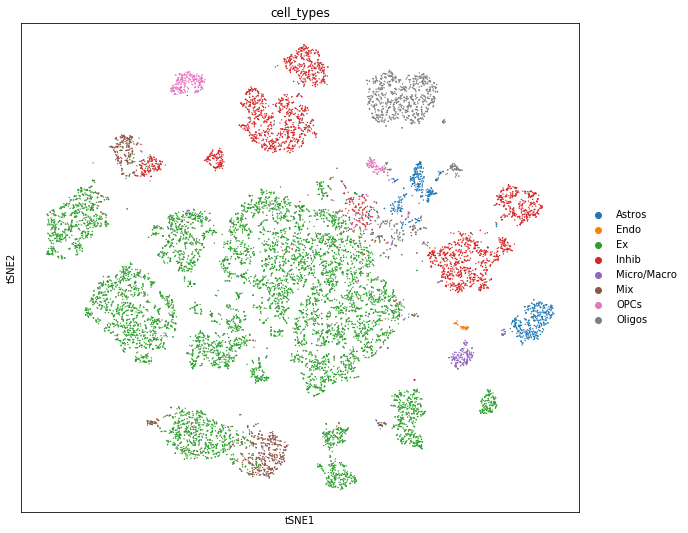

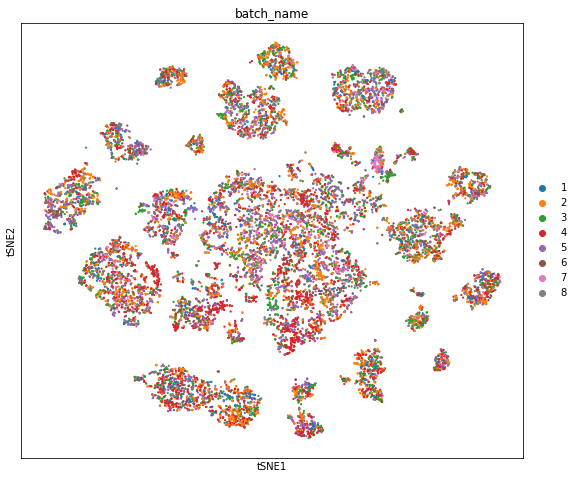

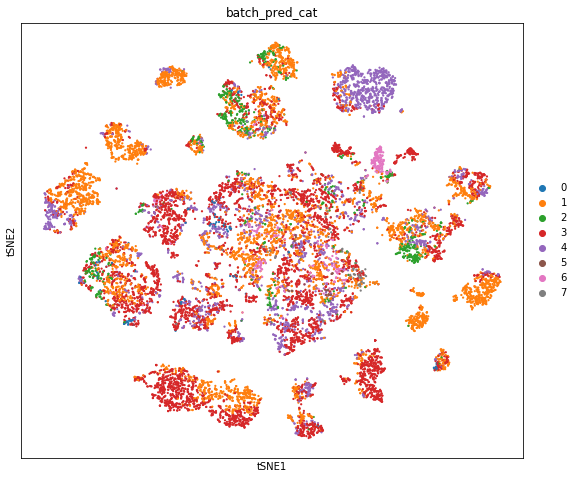

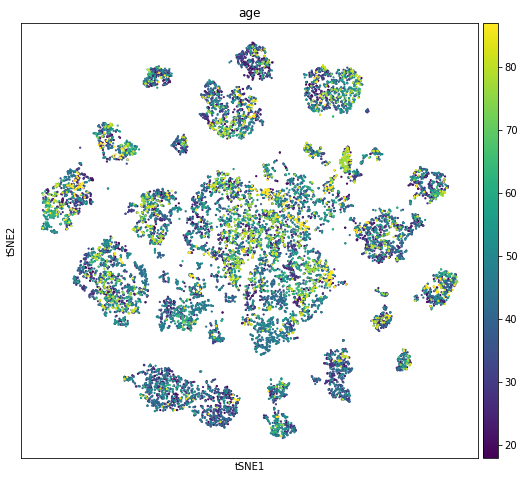

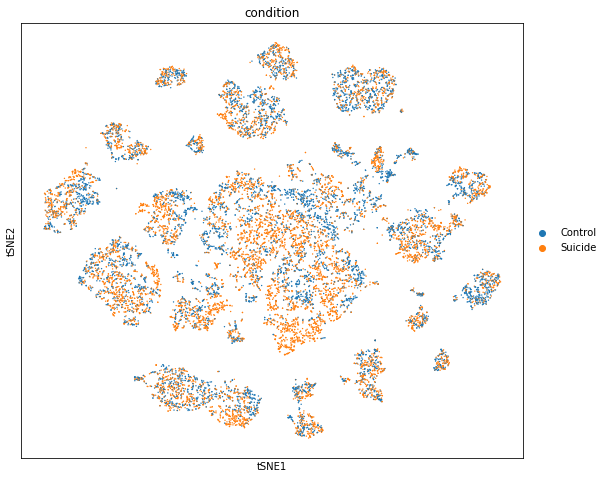

In [39]:
show_plot = True
fig, ax = plt.subplots(figsize=(10, 9))
sc.pl.tsne(adata, color=["cell_types"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=["batch_name"], ax=ax, show=show_plot, size = 20)
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=["batch_pred_cat"], ax=ax, show=show_plot ,size = 20)

fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=["age"], ax=ax, show=show_plot ,size = 20)

fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=["condition"], ax=ax, show=show_plot)

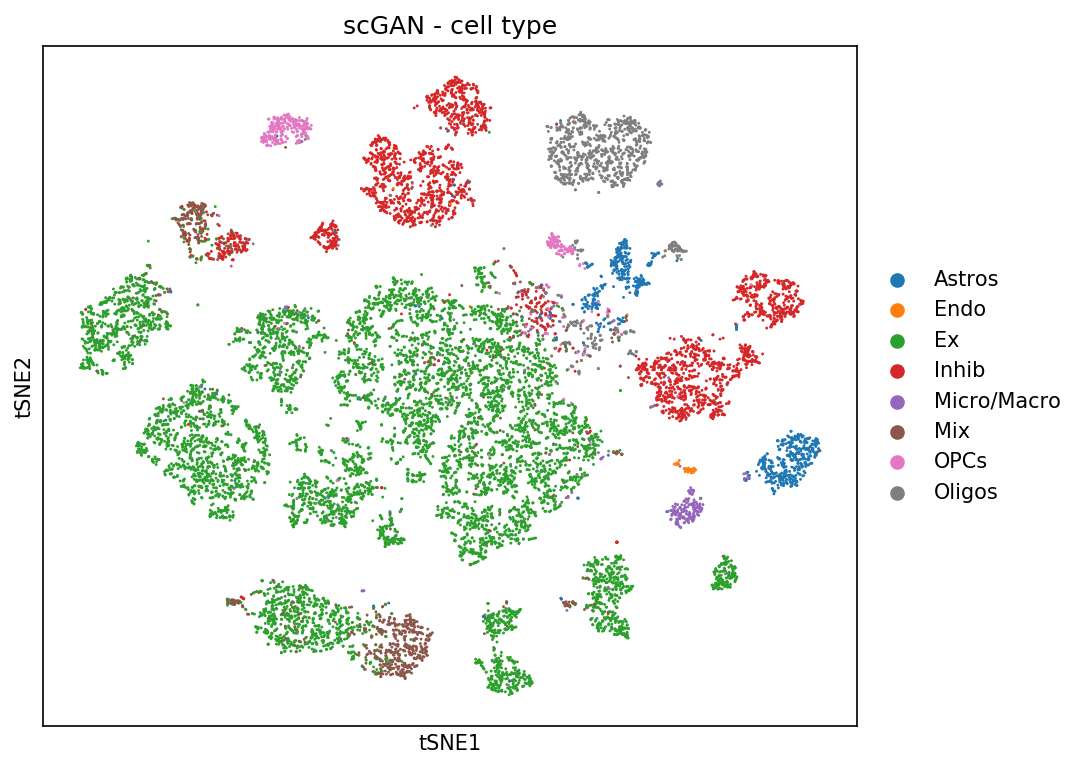

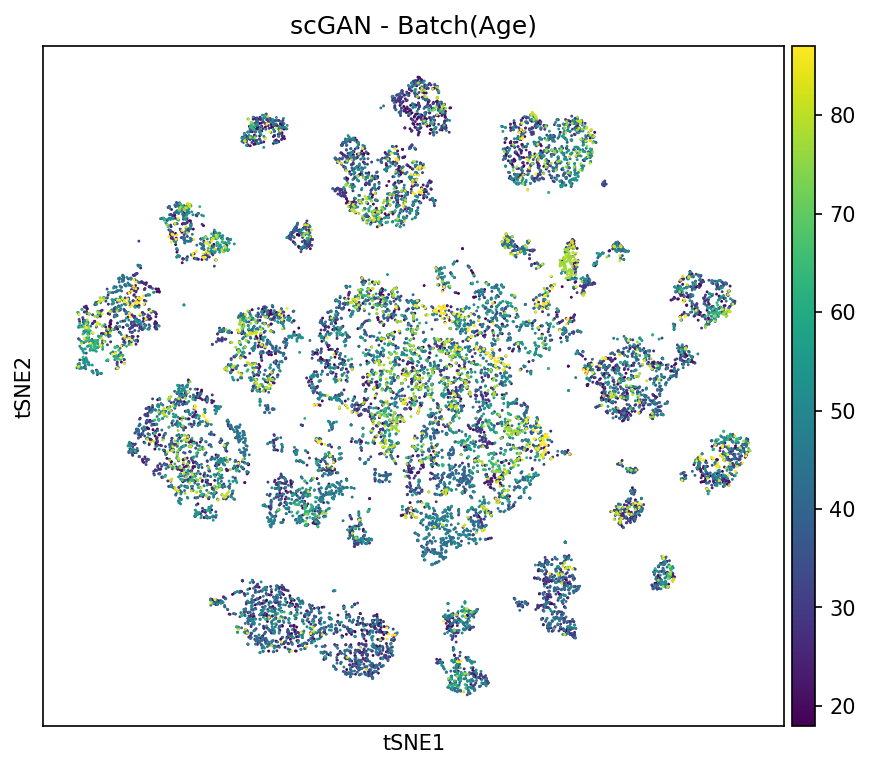

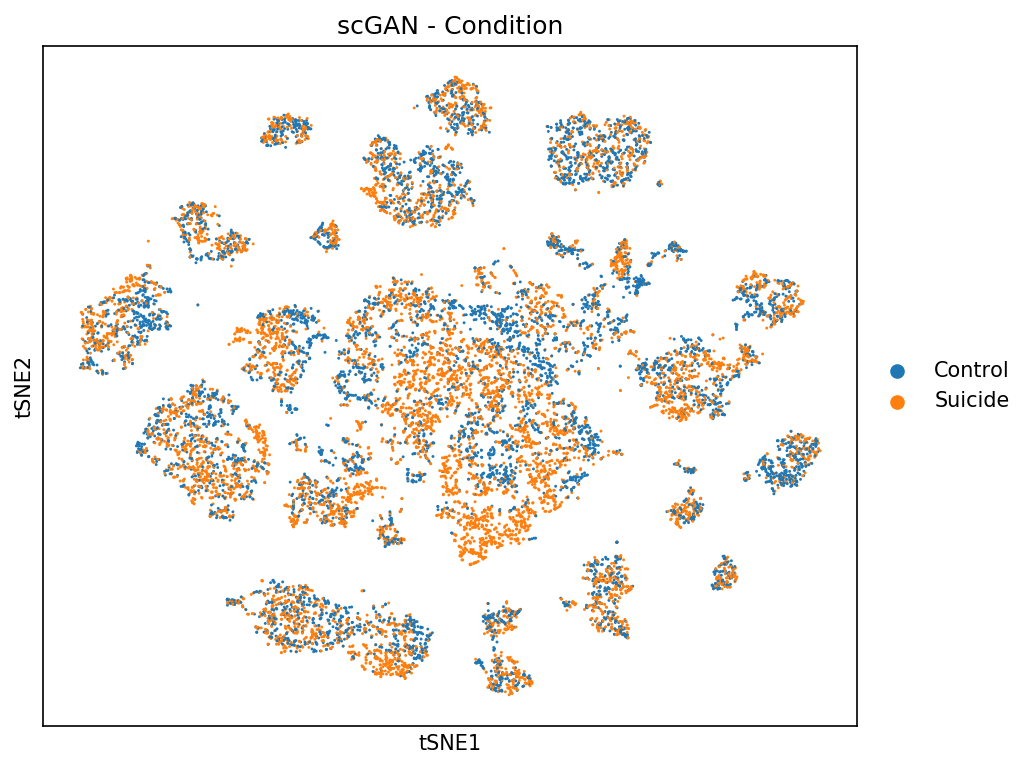

In [110]:
dataset_name = 'Turecki'
method = 'scGAN'
# method = '$scGAN^{-}$(No Adversarial Net)'

fig, ax = plt.subplots(figsize=(7, 6), dpi=150)
sc.pl.tsne(adata, color=["cell_type"], ax=ax, title='{} - cell type'.format(method))
fig.savefig('/home/mcb/users/mbahra5/project/scVI/pics/{}_{}_celltype.png'.format(dataset_name,method), bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=(7, 6),  dpi=150)
sc.pl.tsne(adata, color=["age"], ax=ax, title='{} - Batch(Age)'.format(method))
fig.savefig('/home/mcb/users/mbahra5/project/scVI/pics/{}_{}_batch.png'.format(dataset_name,method), bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=(7, 6) , dpi=150)
sc.pl.tsne(adata, color=["condition"], ax=ax,  title='{} - Condition'.format(method) )
fig.savefig('/home/mcb/users/mbahra5/project/scVI/pics/{}_{}_condition.png'.format(dataset_name,method), bbox_inches = 'tight')

In [ ]:
ari_kmeans , clusters_kmeans = clustering_scores_2(dataset.n_labels, labels, latent, prediction_algorithm='knn')

In [ ]:
print(ari_kmeans)
adata.obs['clusters_kmeans'] = clusters_kmeans.astype('object')
show_plot = True
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=['clusters_kmeans'], ax=ax, show=show_plot)

In [ ]:
from tqdm import tqdm
ari_max, clusters_max = 0.0 , None
ari_max_list = []
c_n = list(range(2, dataset.n_labels+1))
for c in c_n:
    ari_perC_list = []
    for i in tqdm(range(20)):
        ari_gmm = clustering_scores(c, labels, latent, prediction_algorithm='gmm')
        ari_perC_list.append(ari_gmm)
    
    ari_max_list.append(sum(ari_perC_list)/len(ari_perC_list))

#     ari_max_list.append(ari_max_perC)


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(c_n,ari_max_list)
plt.ylabel('ARI (with GMM)')
plt.xlabel('Number of Clusters')
plt.show()

In [ ]:
print(sum(ari_max_list[3:])/len(ari_max_list[3:]))

In [290]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=30)
sc.tl.louvain(adata, resolution=0.20)

/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/single-cell/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


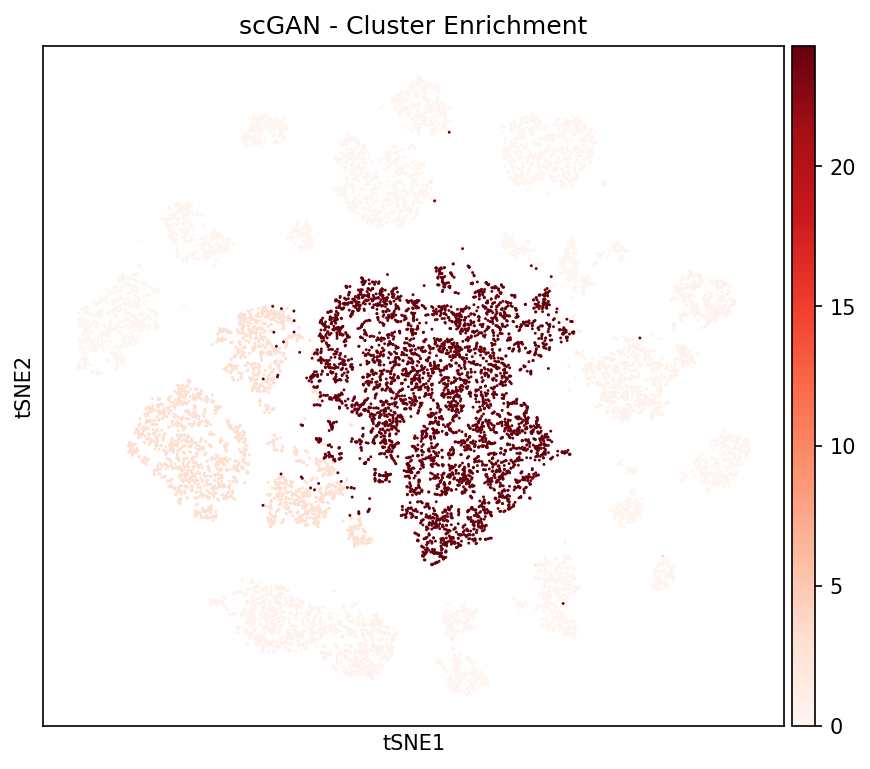

In [221]:
louvain_color = np.ones(adata.shape[0])
for cluster, p in enumerate(pvalues):
    temp_mask = adata.obs['louvain'].values==str(cluster)
    louvain_color[temp_mask] = -np.log10(p)
adata.obs['louvain_color'] = louvain_color

show_plot = True
fig, ax = plt.subplots(figsize=(7, 6),  dpi=150)
sc.pl.tsne(adata, color=['louvain_color'], ax=ax, show=show_plot, color_map='Reds',  title='{} - Cluster Enrichment'.format(method))
fig.savefig('/home/mcb/users/mbahra5/project/scVI/pics/{}_{}_louvain_bypvalue.png'.format(dataset_name,method), bbox_inches = 'tight')


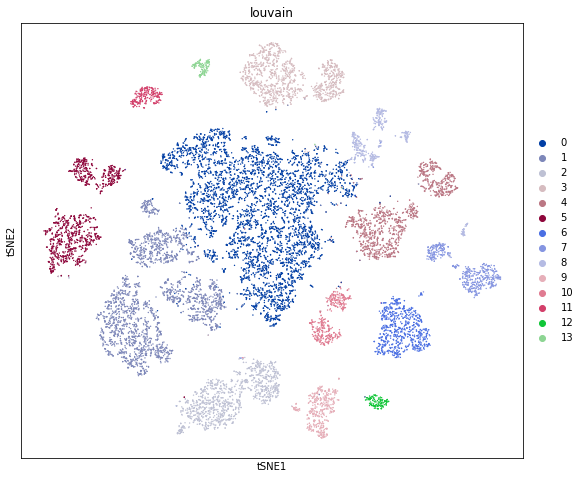

In [291]:
show_plot = True
fig, ax = plt.subplots(figsize=(9, 8))
sc.pl.tsne(adata, color=['louvain'], ax=ax, show=show_plot)

In [292]:
from sklearn.metrics import adjusted_rand_score as ARI
ari_score = ARI(labels, adata.obs['louvain'])
print('Lovain ARI score={}'.format(ari_score))

0.2813066169746887


# Differential Gene Expression 

In [43]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data.iloc[index].values
        label = self.label.iloc[index]
            
        return data, label
    

In [44]:
import torch.nn.functional as F
def train(model, train_loader, optimizer, epochs):
    model.train()
    history = []
    for epoch in tqdm(range(1, epochs)):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                history.append(loss.item())
    return history

In [672]:
preds_train = mdd_classifier(torch.tensor(adata_train.obsm['X_scVI']).to(device))
preds_test = mdd_classifier(torch.tensor(adata_test.obsm['X_scVI']).to(device))

In [673]:
acc_train = (preds_train.argmax(dim=1).detach().cpu().numpy() == adata_train.obs['condition'].cat.codes.astype('long')).mean()
print("acc train: {}".format(acc_train))

acc_test = (preds_test.argmax(dim=1).detach().cpu().numpy() == adata_test.obs['condition'].cat.codes.astype('long')).mean()
print("acc test: {} ".format(acc_test))

acc train: 0.7866494955999142
acc test: 0.8 


## Automatic DE per cluster

In [99]:
psygenet = pd.read_csv("/home/mcb/users/mbahra5/project/scVI/psygenet_v02.txt", sep='\t')
disgenet = pd.read_csv("/home/mcb/users/mbahra5/project/scVI/curated_gene_disease_associations.tsv.gz", sep='\t')
mask1 = psygenet['PsychiatricDisorder']=='Depressive disorders' 
mask2 = psygenet['PsychiatricDisorder']=='Schizophrenia spectrum and other psychotic disorders' 
mask1_dis = disgenet['diseaseName']=='Major Depressive Disorder' 
genes = adata.var.index.values

In [293]:

overlaps=[]
overlaps_dis = []
for cluster in adata.obs['louvain'].cat.categories:
    adata_filter = adata[(adata.obs['louvain']==cluster).values]
    adata_train = adata_filter[:-5]
    adata_test = adata_filter[-5:]
    
    mydataset = MyDataset(data = pd.DataFrame(adata_train.obsm['X_scVI']) , label=adata_train.obs['condition'].cat.codes.astype('long'))
    train_loader = torch.utils.data.DataLoader(mydataset, batch_size=512)
    mdd_classifier = Discriminator(n_latent, [2*n_latent, 2*n_latent], 2).to('cuda:0')
    
    optimizerMDD= torch.optim.Adam(mdd_classifier.parameters(), lr = lr)
    history = train(mdd_classifier, train_loader, optimizerMDD, epochs=30)
    
    gene_dataset = MyDataset(data = pd.DataFrame(adata_train.X.toarray()) , label=adata_train.obs['batch_indices'].astype('long'))
    gene_dataset_loader = torch.utils.data.DataLoader(gene_dataset, batch_size=512)

    grads = []
    for sample_batch, batch_index in tqdm(gene_dataset_loader):
        vae.zero_grad()
        optimizerMDD.zero_grad()
        
        sample_batch = sample_batch.to(device)
        batch_index = batch_index.to(device)
        sample_batch.requires_grad=True
        batch_index = batch_index.reshape((-1,1))
        
        reconst_loss, kl_divergence, z = vae(sample_batch, batch_index)        
        output = mdd_classifier(z)
        output = torch.exp(output)
        output.sum(dim=0)[0].backward()
        grads.append(sample_batch.grad.detach().cpu().numpy())    
    
    grads_per_gene_abs = np.absolute(np.concatenate(grads).sum(axis=0))
    print('grad shape for cluster {} is ={}'.format(cluster,grads_per_gene_abs.shape))
    genes_top = genes[grads_per_gene_abs.argsort()[-50:]]
    
    overlap = np.intersect1d(psygenet[mask1|mask2]['Gene_Symbol'].values, genes_top)
    overlap_dis = np.intersect1d(disgenet[mask1_dis]['geneSymbol'].values, genes_top)
    overlaps.append(overlap)
    overlaps_dis.append(overlap_dis)
    print(overlap)
    print(overlap_dis)



  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:19,  1.43it/s]

  7%|▋         | 2/29 [00:01<00:22,  1.21it/s]

 10%|█         | 3/29 [00:02<00:20,  1.29it/s]

 14%|█▍        | 4/29 [00:03<00:18,  1.35it/s]

 17%|█▋        | 5/29 [00:03<00:17,  1.40it/s]

 21%|██        | 6/29 [00:04<00:16,  1.43it/s]

 24%|██▍       | 7/29 [00:05<00:15,  1.46it/s]

 28%|██▊       | 8/29 [00:05<00:14,  1.48it/s]

 31%|███       | 9/29 [00:06<00:13,  1.51it/s]

 34%|███▍      | 10/29 [00:07<00:12,  1.48it/s]

 38%|███▊      | 11/29 [00:07<00:12,  1.50it/s]

 41%|████▏     | 12/29 [00:08<00:11,  1.52it/s]

 45%|████▍     | 13/29 [00:09<00:10,  1.50it/s]

 48%|████▊     | 14/29 [00:09<00:09,  1.54it/s]

 52%|█████▏    | 15/29 [00:10<00:09,  1.54it/s]

 55%|█████▌    | 16/29 [00:10<00:08,  1.54it/s]

 59%|█████▊    | 17/29 [00:11<00:07,  1.53it/s]

 62%|██████▏   | 18/29 [00:12<00:07,  1.51it/s]

 66%|██████▌   | 19/29 [00:12<00:06,  1.54it/s]

 69%|██████▉   | 20/29 [00:13<00:05,

grad shape for cluster 0 is =(33694,)
['APOE' 'CLDN5' 'DAAM2' 'DLX1' 'EMX2' 'GFAP' 'GLUL' 'KCNJ10' 'MAG' 'MBP'
 'MIR219A2' 'MOBP' 'MOG' 'MT2A' 'PLP1' 'PTGDS' 'QKI']
['GFAP' 'QKI']




  3%|▎         | 1/29 [00:00<00:11,  2.47it/s]

  7%|▋         | 2/29 [00:00<00:10,  2.57it/s]

 10%|█         | 3/29 [00:01<00:10,  2.53it/s]

 14%|█▍        | 4/29 [00:01<00:09,  2.61it/s]

 17%|█▋        | 5/29 [00:01<00:09,  2.60it/s]

 21%|██        | 6/29 [00:02<00:08,  2.68it/s]

 24%|██▍       | 7/29 [00:02<00:08,  2.69it/s]

 28%|██▊       | 8/29 [00:02<00:07,  2.72it/s]

 31%|███       | 9/29 [00:03<00:07,  2.76it/s]

 34%|███▍      | 10/29 [00:03<00:06,  2.80it/s]

 38%|███▊      | 11/29 [00:04<00:06,  2.83it/s]

 41%|████▏     | 12/29 [00:04<00:05,  2.86it/s]

 45%|████▍     | 13/29 [00:04<00:05,  2.86it/s]

 48%|████▊     | 14/29 [00:05<00:05,  2.86it/s]

 52%|█████▏    | 15/29 [00:05<00:04,  2.82it/s]

 55%|█████▌    | 16/29 [00:05<00:04,  2.74it/s]

 59%|█████▊    | 17/29 [00:06<00:04,  2.77it/s]

 62%|██████▏   | 18/29 [00:06<00:03,  2.80it/s]

 66%|██████▌   | 19/29 [00:06<00:03,  2.83it/s]

 69%|██████▉   | 20/29 [00:07<00:03,  2.80it/s]

 72%|███████▏  | 21/29 [00:

grad shape for cluster 1 is =(33694,)
['CLDN5' 'DAAM2' 'DLX1' 'GFAP' 'GLUL' 'KCNJ10' 'MAG' 'MBP' 'MIR219A2'
 'MOBP' 'MOG' 'MT2A' 'PLP1' 'PTGDS' 'QKI']
['GFAP' 'QKI']




  3%|▎         | 1/29 [00:00<00:06,  4.51it/s]

  7%|▋         | 2/29 [00:00<00:05,  4.93it/s]

 10%|█         | 3/29 [00:00<00:05,  5.14it/s]

 14%|█▍        | 4/29 [00:00<00:04,  5.35it/s]

 17%|█▋        | 5/29 [00:00<00:04,  5.48it/s]

 21%|██        | 6/29 [00:01<00:04,  5.63it/s]

 24%|██▍       | 7/29 [00:01<00:03,  5.54it/s]

 28%|██▊       | 8/29 [00:01<00:03,  5.54it/s]

 31%|███       | 9/29 [00:01<00:03,  5.57it/s]

 34%|███▍      | 10/29 [00:01<00:03,  5.60it/s]

 38%|███▊      | 11/29 [00:01<00:03,  5.66it/s]

 41%|████▏     | 12/29 [00:02<00:03,  5.63it/s]

 45%|████▍     | 13/29 [00:02<00:02,  5.57it/s]

 48%|████▊     | 14/29 [00:02<00:02,  5.29it/s]

 52%|█████▏    | 15/29 [00:02<00:02,  5.41it/s]

 55%|█████▌    | 16/29 [00:02<00:02,  5.51it/s]

 59%|█████▊    | 17/29 [00:03<00:02,  5.60it/s]

 62%|██████▏   | 18/29 [00:03<00:01,  5.57it/s]

 66%|██████▌   | 19/29 [00:03<00:01,  5.41it/s]

 69%|██████▉   | 20/29 [00:03<00:01,  5.35it/s]

 72%|███████▏  | 21/29 [00:

grad shape for cluster 2 is =(33694,)
['DGCR8' 'NGFR' 'PLP1' 'PTPRZ1']
[]




  3%|▎         | 1/29 [00:00<00:05,  4.67it/s]

  7%|▋         | 2/29 [00:00<00:05,  4.87it/s]

 10%|█         | 3/29 [00:00<00:05,  5.16it/s]

 14%|█▍        | 4/29 [00:00<00:04,  5.39it/s]

 17%|█▋        | 5/29 [00:00<00:04,  5.60it/s]

 21%|██        | 6/29 [00:01<00:04,  5.74it/s]

 24%|██▍       | 7/29 [00:01<00:03,  5.89it/s]

 28%|██▊       | 8/29 [00:01<00:03,  5.95it/s]

 31%|███       | 9/29 [00:01<00:03,  6.01it/s]

 34%|███▍      | 10/29 [00:01<00:03,  6.01it/s]

 38%|███▊      | 11/29 [00:01<00:03,  6.00it/s]

 41%|████▏     | 12/29 [00:02<00:02,  6.01it/s]

 45%|████▍     | 13/29 [00:02<00:02,  5.86it/s]

 48%|████▊     | 14/29 [00:02<00:02,  5.81it/s]

 52%|█████▏    | 15/29 [00:02<00:02,  5.76it/s]

 55%|█████▌    | 16/29 [00:02<00:02,  5.75it/s]

 59%|█████▊    | 17/29 [00:02<00:02,  5.73it/s]

 62%|██████▏   | 18/29 [00:03<00:01,  5.66it/s]

 66%|██████▌   | 19/29 [00:03<00:01,  5.49it/s]

 69%|██████▉   | 20/29 [00:03<00:01,  5.35it/s]

 72%|███████▏  | 21/29 [00:

grad shape for cluster 3 is =(33694,)
['A2M' 'CLDN5' 'DAAM2' 'GLUL' 'MLC1' 'PTGDS']
[]




  3%|▎         | 1/29 [00:00<00:06,  4.25it/s]

  7%|▋         | 2/29 [00:00<00:05,  4.64it/s]

 10%|█         | 3/29 [00:00<00:05,  4.94it/s]

 14%|█▍        | 4/29 [00:00<00:04,  5.24it/s]

 17%|█▋        | 5/29 [00:00<00:04,  5.44it/s]

 21%|██        | 6/29 [00:01<00:04,  5.60it/s]

 24%|██▍       | 7/29 [00:01<00:03,  5.76it/s]

 28%|██▊       | 8/29 [00:01<00:03,  5.87it/s]

 31%|███       | 9/29 [00:01<00:03,  5.94it/s]

 34%|███▍      | 10/29 [00:01<00:03,  6.00it/s]

 38%|███▊      | 11/29 [00:01<00:03,  5.98it/s]

 41%|████▏     | 12/29 [00:02<00:02,  6.06it/s]

 45%|████▍     | 13/29 [00:02<00:02,  6.06it/s]

 48%|████▊     | 14/29 [00:02<00:02,  6.05it/s]

 52%|█████▏    | 15/29 [00:02<00:02,  6.01it/s]

 55%|█████▌    | 16/29 [00:02<00:02,  5.93it/s]

 59%|█████▊    | 17/29 [00:02<00:02,  5.92it/s]

 62%|██████▏   | 18/29 [00:03<00:01,  5.87it/s]

 66%|██████▌   | 19/29 [00:03<00:01,  5.84it/s]

 69%|██████▉   | 20/29 [00:03<00:01,  5.73it/s]

 72%|███████▏  | 21/29 [00:

grad shape for cluster 4 is =(33694,)
['CSF2RA' 'DAAM2' 'GLUL' 'PLP1' 'PTGDS']
[]




  3%|▎         | 1/29 [00:00<00:06,  4.32it/s]

  7%|▋         | 2/29 [00:00<00:05,  4.84it/s]

 10%|█         | 3/29 [00:00<00:05,  5.15it/s]

 14%|█▍        | 4/29 [00:00<00:04,  5.39it/s]

 17%|█▋        | 5/29 [00:00<00:04,  5.54it/s]

 21%|██        | 6/29 [00:01<00:04,  5.70it/s]

 24%|██▍       | 7/29 [00:01<00:03,  5.88it/s]

 28%|██▊       | 8/29 [00:01<00:03,  5.89it/s]

 31%|███       | 9/29 [00:01<00:03,  6.01it/s]

 34%|███▍      | 10/29 [00:01<00:03,  5.93it/s]

 38%|███▊      | 11/29 [00:01<00:03,  5.98it/s]

 41%|████▏     | 12/29 [00:02<00:02,  5.97it/s]

 45%|████▍     | 13/29 [00:02<00:02,  5.99it/s]

 48%|████▊     | 14/29 [00:02<00:02,  5.86it/s]

 52%|█████▏    | 15/29 [00:02<00:02,  6.05it/s]

 55%|█████▌    | 16/29 [00:02<00:02,  6.00it/s]

 59%|█████▊    | 17/29 [00:02<00:02,  5.86it/s]

 62%|██████▏   | 18/29 [00:03<00:01,  5.83it/s]

 66%|██████▌   | 19/29 [00:03<00:01,  5.83it/s]

 69%|██████▉   | 20/29 [00:03<00:01,  5.59it/s]

 72%|███████▏  | 21/29 [00:

grad shape for cluster 5 is =(33694,)
['CLDN5' 'CRHBP' 'DAAM2' 'EMX2' 'GFAP' 'GLUL' 'KCNJ10' 'MAG' 'MBP' 'MT2A'
 'PLLP' 'PLP1' 'PTGDS' 'S100B']
['CRHBP' 'GFAP' 'S100B']




  3%|▎         | 1/29 [00:00<00:04,  6.54it/s]

  7%|▋         | 2/29 [00:00<00:03,  7.00it/s]

 10%|█         | 3/29 [00:00<00:03,  7.59it/s]

 14%|█▍        | 4/29 [00:00<00:03,  7.33it/s]

 17%|█▋        | 5/29 [00:00<00:03,  7.84it/s]

 21%|██        | 6/29 [00:00<00:02,  8.18it/s]

 24%|██▍       | 7/29 [00:00<00:02,  7.81it/s]

 28%|██▊       | 8/29 [00:00<00:02,  8.18it/s]

 31%|███       | 9/29 [00:01<00:02,  7.83it/s]

 34%|███▍      | 10/29 [00:01<00:02,  7.72it/s]

 38%|███▊      | 11/29 [00:01<00:02,  8.07it/s]

 41%|████▏     | 12/29 [00:01<00:02,  8.23it/s]

 45%|████▍     | 13/29 [00:01<00:01,  8.45it/s]

 48%|████▊     | 14/29 [00:01<00:01,  8.60it/s]

 52%|█████▏    | 15/29 [00:01<00:01,  8.73it/s]

 55%|█████▌    | 16/29 [00:01<00:01,  8.79it/s]

 59%|█████▊    | 17/29 [00:02<00:01,  8.85it/s]

 62%|██████▏   | 18/29 [00:02<00:01,  8.88it/s]

 66%|██████▌   | 19/29 [00:02<00:01,  8.18it/s]

 69%|██████▉   | 20/29 [00:02<00:01,  8.27it/s]

 72%|███████▏  | 21/29 [00:

grad shape for cluster 6 is =(33694,)
['A2M' 'CLDN5' 'HLA-B' 'HLA-E' 'PTPN6']
[]




  7%|▋         | 2/29 [00:00<00:02,  9.36it/s]

 14%|█▍        | 4/29 [00:00<00:02, 10.39it/s]

 21%|██        | 6/29 [00:00<00:02, 11.04it/s]

 28%|██▊       | 8/29 [00:00<00:01, 11.40it/s]

 34%|███▍      | 10/29 [00:00<00:01, 11.68it/s]

 41%|████▏     | 12/29 [00:00<00:01, 11.84it/s]

 48%|████▊     | 14/29 [00:01<00:01, 11.80it/s]

 55%|█████▌    | 16/29 [00:01<00:01, 11.81it/s]

 62%|██████▏   | 18/29 [00:01<00:00, 11.42it/s]

 69%|██████▉   | 20/29 [00:01<00:00, 11.60it/s]

 76%|███████▌  | 22/29 [00:01<00:00, 11.69it/s]

 83%|████████▎ | 24/29 [00:02<00:00, 11.84it/s]

 90%|████████▉ | 26/29 [00:02<00:00, 11.84it/s]

100%|██████████| 29/29 [00:02<00:00, 11.80it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

grad shape for cluster 7 is =(33694,)
['AGT' 'APOE' 'CLDN5' 'EMX2' 'GFAP' 'GJA1' 'GLUL' 'HLA-E' 'KCNJ10' 'MLC1'
 'MT2A' 'PTGDS']
['GFAP' 'GJA1']




  7%|▋         | 2/29 [00:00<00:02, 10.56it/s]

 14%|█▍        | 4/29 [00:00<00:02, 11.64it/s]

 21%|██        | 6/29 [00:00<00:01, 12.55it/s]

 28%|██▊       | 8/29 [00:00<00:01, 12.93it/s]

 34%|███▍      | 10/29 [00:00<00:01, 13.44it/s]

 41%|████▏     | 12/29 [00:00<00:01, 13.73it/s]

 48%|████▊     | 14/29 [00:01<00:01, 14.00it/s]

 55%|█████▌    | 16/29 [00:01<00:00, 14.16it/s]

 62%|██████▏   | 18/29 [00:01<00:00, 14.40it/s]

 69%|██████▉   | 20/29 [00:01<00:00, 14.46it/s]

 76%|███████▌  | 22/29 [00:01<00:00, 13.52it/s]

 83%|████████▎ | 24/29 [00:01<00:00, 12.89it/s]

 90%|████████▉ | 26/29 [00:01<00:00, 12.88it/s]

100%|██████████| 29/29 [00:02<00:00, 13.78it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  9.05it/s]

grad shape for cluster 8 is =(33694,)
['APOD' 'CLDN5' 'HLA-B' 'HLA-E' 'MAG' 'PTPN6']
[]




 10%|█         | 3/29 [00:00<00:02,  9.52it/s]

 17%|█▋        | 5/29 [00:00<00:02, 10.43it/s]

 24%|██▍       | 7/29 [00:00<00:01, 11.50it/s]

 31%|███       | 9/29 [00:00<00:01, 12.21it/s]

 38%|███▊      | 11/29 [00:00<00:01, 12.39it/s]

 45%|████▍     | 13/29 [00:01<00:01, 12.95it/s]

 52%|█████▏    | 15/29 [00:01<00:01, 13.51it/s]

 59%|█████▊    | 17/29 [00:01<00:00, 13.32it/s]

 66%|██████▌   | 19/29 [00:01<00:00, 13.68it/s]

 72%|███████▏  | 21/29 [00:01<00:00, 14.00it/s]

 79%|███████▉  | 23/29 [00:01<00:00, 14.28it/s]

 86%|████████▌ | 25/29 [00:01<00:00, 14.34it/s]

 93%|█████████▎| 27/29 [00:01<00:00, 14.40it/s]

100%|██████████| 29/29 [00:02<00:00, 13.69it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

grad shape for cluster 9 is =(33694,)
['CARTPT' 'CRHBP' 'EMX2' 'GRIK1' 'GRIK3' 'GRIP1' 'NRG1' 'TAC1']
['CRHBP' 'TAC1']




  7%|▋         | 2/29 [00:00<00:02, 11.65it/s]

 14%|█▍        | 4/29 [00:00<00:02, 12.33it/s]

 21%|██        | 6/29 [00:00<00:01, 12.69it/s]

 28%|██▊       | 8/29 [00:00<00:01, 13.65it/s]

 34%|███▍      | 10/29 [00:00<00:01, 14.30it/s]

 41%|████▏     | 12/29 [00:00<00:01, 14.96it/s]

 48%|████▊     | 14/29 [00:00<00:00, 15.06it/s]

 55%|█████▌    | 16/29 [00:01<00:00, 15.46it/s]

 62%|██████▏   | 18/29 [00:01<00:00, 15.89it/s]

 69%|██████▉   | 20/29 [00:01<00:00, 16.22it/s]

 76%|███████▌  | 22/29 [00:01<00:00, 16.34it/s]

 83%|████████▎ | 24/29 [00:01<00:00, 16.53it/s]

 90%|████████▉ | 26/29 [00:01<00:00, 16.50it/s]

100%|██████████| 29/29 [00:01<00:00, 15.63it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

  7%|▋         | 2/29 [00:00<00:01, 18.07it/s]

grad shape for cluster 10 is =(33694,)
['A2M' 'CSF2RA' 'OLIG2' 'PLLP' 'PTPN6' 'S100B' 'SOX6']
['S100B']




 14%|█▍        | 4/29 [00:00<00:01, 17.80it/s]

 21%|██        | 6/29 [00:00<00:01, 17.78it/s]

 31%|███       | 9/29 [00:00<00:01, 19.46it/s]

 41%|████▏     | 12/29 [00:00<00:00, 19.92it/s]

 52%|█████▏    | 15/29 [00:00<00:00, 20.60it/s]

 62%|██████▏   | 18/29 [00:00<00:00, 21.71it/s]

 72%|███████▏  | 21/29 [00:00<00:00, 23.19it/s]

 83%|████████▎ | 24/29 [00:01<00:00, 23.90it/s]

100%|██████████| 29/29 [00:01<00:00, 22.83it/s]


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

grad shape for cluster 11 is =(33694,)
['CSF2RA' 'EMX2' 'GRIA4' 'MT2A' 'NRG1']
['GRIA4']




 14%|█▍        | 4/29 [00:00<00:00, 29.82it/s]

 24%|██▍       | 7/29 [00:00<00:00, 29.57it/s]

 38%|███▊      | 11/29 [00:00<00:00, 30.92it/s]

 52%|█████▏    | 15/29 [00:00<00:00, 31.26it/s]

 62%|██████▏   | 18/29 [00:00<00:00, 30.22it/s]

 79%|███████▉  | 23/29 [00:00<00:00, 32.90it/s]

100%|██████████| 29/29 [00:00<00:00, 32.84it/s]


100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

 14%|█▍        | 4/29 [00:00<00:00, 37.37it/s]

grad shape for cluster 12 is =(33694,)
['CLDN5' 'DAAM2' 'DISC1' 'GLUL' 'HLA-E' 'KCNJ10' 'KCNK9' 'MLC1' 'PTGDS'
 'PTPN6' 'PTPRZ1']
['DISC1']




 28%|██▊       | 8/29 [00:00<00:00, 37.40it/s]

 45%|████▍     | 13/29 [00:00<00:00, 38.71it/s]

 62%|██████▏   | 18/29 [00:00<00:00, 40.64it/s]

 79%|███████▉  | 23/29 [00:00<00:00, 41.82it/s]

100%|██████████| 29/29 [00:00<00:00, 42.10it/s]


100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


grad shape for cluster 13 is =(33694,)
['CLDN5' 'DISC1' 'KCNJ10' 'MEGF10' 'MLC1' 'PTPN6']
['DISC1']


In [294]:
for i, ov in enumerate(overlaps):
    print("DEGs for cluster {}:{}".format(i, ', '.join(list(ov))))


DEGs for cluster 0:APOE, CLDN5, DAAM2, DLX1, EMX2, GFAP, GLUL, KCNJ10, MAG, MBP, MIR219A2, MOBP, MOG, MT2A, PLP1, PTGDS, QKI
DEGs for cluster 1:CLDN5, DAAM2, DLX1, GFAP, GLUL, KCNJ10, MAG, MBP, MIR219A2, MOBP, MOG, MT2A, PLP1, PTGDS, QKI
DEGs for cluster 2:DGCR8, NGFR, PLP1, PTPRZ1
DEGs for cluster 3:A2M, CLDN5, DAAM2, GLUL, MLC1, PTGDS
DEGs for cluster 4:CSF2RA, DAAM2, GLUL, PLP1, PTGDS
DEGs for cluster 5:CLDN5, CRHBP, DAAM2, EMX2, GFAP, GLUL, KCNJ10, MAG, MBP, MT2A, PLLP, PLP1, PTGDS, S100B
DEGs for cluster 6:A2M, CLDN5, HLA-B, HLA-E, PTPN6
DEGs for cluster 7:AGT, APOE, CLDN5, EMX2, GFAP, GJA1, GLUL, HLA-E, KCNJ10, MLC1, MT2A, PTGDS
DEGs for cluster 8:APOD, CLDN5, HLA-B, HLA-E, MAG, PTPN6
DEGs for cluster 9:CARTPT, CRHBP, EMX2, GRIK1, GRIK3, GRIP1, NRG1, TAC1
DEGs for cluster 10:A2M, CSF2RA, OLIG2, PLLP, PTPN6, S100B, SOX6
DEGs for cluster 11:CSF2RA, EMX2, GRIA4, MT2A, NRG1
DEGs for cluster 12:CLDN5, DAAM2, DISC1, GLUL, HLA-E, KCNJ10, KCNK9, MLC1, PTGDS, PTPN6, PTPRZ1
DEGs for cluste

## Automatic DE across all clusters

In [223]:

overlaps=[]
overlaps_dis = []
grads_all_clusters =[]
for cluster in adata.obs['louvain'].cat.categories:
    adata_filter = adata[(adata.obs['louvain']==cluster).values]
    adata_train = adata_filter[:-5]
    adata_test = adata_filter[-5:]
    
    mydataset = MyDataset(data = pd.DataFrame(adata_train.obsm['X_scVI']) , label=adata_train.obs['condition'].cat.codes.astype('long'))
    train_loader = torch.utils.data.DataLoader(mydataset, batch_size=512)
    mdd_classifier = Discriminator(n_latent, [2*n_latent, 2*n_latent], 2).to('cuda:0')
    
    optimizerMDD= torch.optim.Adam(mdd_classifier.parameters(), lr = lr)
    history = train(mdd_classifier, train_loader, optimizerMDD, epochs=30)
    
    gene_dataset = MyDataset(data = pd.DataFrame(adata_train.X.toarray()) , label=adata_train.obs['batch_indices'].astype('long'))
    gene_dataset_loader = torch.utils.data.DataLoader(gene_dataset, batch_size=512)

    grads = []
    for sample_batch, batch_index in tqdm(gene_dataset_loader):
        vae.zero_grad()
        optimizerMDD.zero_grad()
        
        sample_batch = sample_batch.to(device)
        batch_index = batch_index.to(device)
        sample_batch.requires_grad=True
        batch_index = batch_index.reshape((-1,1))
        
        reconst_loss, kl_divergence, z = vae(sample_batch, batch_index)        
        output = mdd_classifier(z)
        output = torch.exp(output)
        output.sum(dim=0)[0].backward()
        grads.append(sample_batch.grad.detach().cpu().numpy())    
    
    grads_per_gene_abs = np.absolute(np.concatenate(grads).mean(axis=0))
    grads_all_clusters.append(grads_per_gene_abs)




  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:19,  1.43it/s]

  7%|▋         | 2/29 [00:01<00:17,  1.50it/s]

 10%|█         | 3/29 [00:01<00:16,  1.55it/s]

 14%|█▍        | 4/29 [00:02<00:15,  1.58it/s]

 17%|█▋        | 5/29 [00:03<00:15,  1.59it/s]

 21%|██        | 6/29 [00:03<00:14,  1.58it/s]

 24%|██▍       | 7/29 [00:04<00:14,  1.55it/s]

 28%|██▊       | 8/29 [00:05<00:13,  1.54it/s]

 31%|███       | 9/29 [00:05<00:12,  1.56it/s]

 34%|███▍      | 10/29 [00:06<00:12,  1.58it/s]

 38%|███▊      | 11/29 [00:06<00:11,  1.58it/s]

 41%|████▏     | 12/29 [00:07<00:10,  1.61it/s]

 45%|████▍     | 13/29 [00:08<00:09,  1.62it/s]

 48%|████▊     | 14/29 [00:08<00:09,  1.61it/s]

 52%|█████▏    | 15/29 [00:09<00:08,  1.59it/s]

 55%|█████▌    | 16/29 [00:10<00:08,  1.57it/s]

 59%|█████▊    | 17/29 [00:10<00:07,  1.58it/s]

 62%|██████▏   | 18/29 [00:11<00:06,  1.59it/s]

 66%|██████▌   | 19/29 [00:11<00:06,  1.59it/s]

 69%|██████▉   | 20/29 [00:12<00:05,

In [349]:
print('Overlaps with PsyGeNet:')
for top in [5, 10 , 50]:
    grads_agg = np.array(grads_all_clusters).max(axis=0)
    genes_top = genes[grads_agg.argsort()[-top:]]

    overlap = np.intersect1d(psygenet[mask1|mask2]['Gene_Symbol'].values, genes_top)
    overlap_dis = np.intersect1d(disgenet[mask1_dis]['geneSymbol'].values, genes_top)
#     print("DEGs for top {}: {}".format(top, ', '.join(list(overlap))))
    print("DEGs for top {}: {}".format(top, len(overlap)))
    

Overlaps with PsyGeNet:
DEGs for top 5: 3
DEGs for top 10: 5
DEGs for top 50: 17


### Overlap with GWAS

In [428]:
gwas = pd.read_csv("/home/mcb/users/mbahra5/project/scVI/gwas-association-downloaded_2020-04-22-EFO_0003761-withChildTraits.tsv", sep='\t')
mask_gwas = gwas['DISEASE/TRAIT'].apply(lambda x : ('Major depressive disorder' in x) | ('major depressive disorder' in x))

In [442]:
gwas = gwas[mask_gwas]

In [443]:
gwas_genes = []
for g in gwas['MAPPED_GENE']:    
    g = str(g).replace(' - ',', ').replace('; ',', ')
    if ', ' in g:
        gwas_genes.extend(g.split(', '))

In [450]:
print('Overlaps with GWAS:')
for top in [5, 10 , 50, 100]:
    grads_agg = np.array(grads_all_clusters).sum(axis=0)
    genes_top = genes[grads_agg.argsort()[-top:]]

    overlap = np.intersect1d(gwas_genes, genes_top)
    overlap_dis = np.intersect1d(gwas_genes, genes_top)
#     print("DEGs for top {}: {}".format(top, ', '.join(list(overlap))))
    print("DEGs for top {}: {}".format(top, len(overlap)))
    print(overlap)

Overlaps with GWAS:
DEGs for top 5: 1
['CLDN5']
DEGs for top 10: 1
['CLDN5']
DEGs for top 50: 3
['CLDN5' 'ITPKB' 'VCAN']
DEGs for top 100: 3
['CLDN5' 'ITPKB' 'VCAN']


# DE by LMM

In [375]:
sc.pp.log1p(adata)

In [47]:
from pymer4.models import Lm, Lmer

# adata_log = sc.pp.log1p(adata, copy=True)
adata_log = adata
pvals=[]

for cluster in adata.obs['louvain'].cat.categories:
    print('cluster=' + str(cluster))
    mask = (adata.obs['louvain']==cluster).values
    adata_log = adata[mask]
    
    df = pd.DataFrame(adata_log.obsm['X_'], columns=["IV"+str(x) for x in range(10)], index=adata_log.obs.index)
    df['condition'] = adata_log.obs['condition'].values
    df['patient_id'] = adata_log.obs['patient_id'].values
    
    sc.pp.highly_variable_genes(adata_log, n_top_genes=5000)
    adata_log = adata_log[:,adata_log.var.highly_variable]
    genes_highvar = adata_log.var.index.values
    
    pvals_per_cluster = []
    for i , gene_name in enumerate(genes_highvar):
        gene = adata_log[:,i]
        df['gene'] = gene.X
    #     df['gene'] = np.random.rand(gene.X.shape[0])
    #     df['gene'] = df['condition'].cat.codes + np.random.rand(gene.shape[0])

        model = Lm('gene ~ 1 + condition + age_bin + patient_id',data=df)
#         model = Lmer('gene ~ 1 + condition + (1|patient_id) + IV0 + IV1 + IV2 + IV3 + IV4 + IV5 + IV6 + IV7 + IV8 + IV9',data=df)
        model.fit(summarize=False)
        pvals_per_cluster.append([model.coefs['P-val'][1] , model.coefs['Estimate'][1], gene_name])
        
    pvals.append(pvals_per_cluster)
    

cluster=0


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


cluster=1


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


cluster=2


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/pymer4/utils.py:233: RuntimeWarning: invalid value encountered in true_divide
  t = b / se
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mcb/use

cluster=3


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/pymer4/utils.py:233: RuntimeWarning: invalid value encountered in true_divide
  t = b / se
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mcb/use

cluster=4


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/pymer4/utils.py:233: RuntimeWarning: invalid value encountered in true_divide
  t = b / se
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mcb/use

cluster=5


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


cluster=6


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


cluster=7


Trying to set attribute `.var` of view, making a copy.
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/pymer4/utils.py:233: RuntimeWarning: invalid value encountered in true_divide
  t = b / se
/home/mcb/users/mbahra5/anaconda3/envs/single-cell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mcb/use

# DE across all clusters by LMM

In [48]:
gene_scores = []
for k , pvals_per_cluster in enumerate(pvals):
    gene_score = pd.DataFrame(pvals_per_cluster,columns=['pval','estimate','gene'])
    gene_scores.append(gene_score)
  

In [49]:
genes_pvalues = pd.concat(gene_scores, axis=0).groupby('gene').min()

In [50]:
for top in [5, 10 , 50 , 100]:
    genes_top = genes_pvalues.sort_values('pval').index[:top].values
    overlap = np.intersect1d(psygenet[mask1|mask2]['Gene_Symbol'].values, genes_top)
    overlap_dis = np.intersect1d(disgenet[mask1_dis]['geneSymbol'].values, genes_top)
    print("DEGs for top {}: {}".format(top, len(overlap)))

DEGs for top 5: 1
DEGs for top 10: 1
DEGs for top 50: 7
DEGs for top 100: 15


# Cluster Enrichment Analysis

In [155]:
from scipy.stats import hypergeom
suicide_numbers_total = (adata.obs.condition=='Suicide').values.sum()
pvalues = []
for cluster in adata.obs['louvain'].cat.categories:
    adata_filter = adata[(adata.obs['louvain']==cluster).values]
    suicide_numbers = (adata_filter.obs.condition=='Suicide').values.sum()
    p_value = hypergeom.sf(k = suicide_numbers-1, M = adata.shape[0] , n = suicide_numbers_total, N = adata_filter.shape[0], loc=0)
    print('P-value of Hyper test for cluster {} = {}'.format(cluster,p_value))
    pvalues.append(p_value)

P-value of Hyper test for cluster 0 = 4.981480008065665e-25
P-value of Hyper test for cluster 1 = 0.0008631031387257706
P-value of Hyper test for cluster 2 = 0.9984263650579213
P-value of Hyper test for cluster 3 = 0.3631390991467157
P-value of Hyper test for cluster 4 = 0.338844355577274
P-value of Hyper test for cluster 5 = 0.9901672392744629
P-value of Hyper test for cluster 6 = 0.999999999999996
P-value of Hyper test for cluster 7 = 0.9999999999818384
P-value of Hyper test for cluster 8 = 0.7345213963113826
P-value of Hyper test for cluster 9 = 0.9999999999458529
P-value of Hyper test for cluster 10 = 0.9256009637000886
P-value of Hyper test for cluster 11 = 0.8579727173890275
P-value of Hyper test for cluster 12 = 0.5660729258097515


# UMAP

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

In [ ]:
show_plot = True
fig, ax = plt.subplots(figsize=(10, 9))
sc.pl.umap(adata, color=["cell_type"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(10, 9))
sc.pl.umap(adata, color=["batch_name"], ax=ax, show=show_plot)
